# Model

## Imports

In [12]:
import random
import matplotlib.pyplot as plt
from scipy import stats


## Define model class

In [48]:
class Model():

    def __init__(self, num_of_agents=10, num_iterations=10, mode ='homogeneous'):
        '''
        FOR HETEROGENEITY: I introduced different classes of susceptiblility
        through time, agents move between each group. 
        '''
        
        self.agent_types = ['low', 'moderate', 'high']


        self.num_iterations = num_iterations
        
        self.mode = mode

        self.num_infected_per_iteration = []
        
        '''
        FOR HETEROGENEITY: to keep count of agent types
        '''
        self.num_low_sus_per_iteration = []
        self.num_mod_sus_per_iteration = []
        self.num_high_sus_per_iteration = []

        #model time
        self.time = 0
        
        '''
        FOR HETEROGENEITY: random.choice allocates agents to a class of susceptibility
        '''
        # Create the agents
        # All agents in the model
        
        self.agents = []
        for i in range(num_of_agents):
            # adding each new created agent to a list
            if self.mode == 'homogeneous':
                self.agents.append(Agent(self))
            if self.mode == 'basic_heterogeneous' or self.mode == 'adv_heterogeneous':
                self.agents.append(Agent(self, agent_types=random.choice(self.agent_types)))
        
        # if the model hasn't finished running yet
        self.model_finished = False 
                               
        '''
        FOR HETEROGENEITY: to get the number of agents susceptible class
        '''         
    def get_num_infected(self):
        # gets number of agents that are infected
        return len([ a for a in self.agents if a.state==1 ]) 

    def get_num_low_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='low' ]) 
    
    def get_num_mod_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='moderate' ]) 
    
    def get_num_high_sus(self):
        return len([ a for a in self.agents if a.state==0 and a.agent_types=='high' ]) 
    
                               
        '''
        FOR HETEROGENEITY: capturing the numbers of agents in each susceptibility class
        '''   
    def run(self):
        for t in range(self.num_iterations):
            for agent in self.agents:
                # every agent, in every iteration, moves forward
                agent.step()
                
            
            self.num_infected_per_iteration.append(self.get_num_infected())
            self.num_low_sus_per_iteration.append(self.get_num_low_sus())
            self.num_mod_sus_per_iteration.append(self.get_num_mod_sus())
            self.num_high_sus_per_iteration.append(self.get_num_high_sus())
        
            if self.mode == 'homogeneous':
                print('step: {}, total infected:{}'.format(t,self.get_num_infected()))
            if self.mode == 'basic_heterogeneous' or self.mode == 'adv heterogenous':
                 print('step: {}, low:{}, mod:{}, high:{}'.format(t, self.get_num_low_sus(), self.get_num_mod_sus(), self.get_num_high_sus()))
    
        
        # Step time
        self.time += 1

        
         # once each iteration is done, model is finished
        self.model_finished = True 
                               
                               
        '''
        FOR HETEROGENEITY: plotting each susceptiblity class
        ''' 
    def graph_num_infected(self):
        """
        Uses matplotlib to create a graph
        """
        if not self.model_finished:
            print("Can't print the number of infected until the model has finished")
            return
        
        # Create a figure and an axis (if you want more than one plot in the same
        # figure you can adjust the subplots function)
        
        fig, ax = plt.subplots(num=None, figsize=(5, 3), dpi=128, facecolor='w', edgecolor='k')
        
        # Do a scatter plot
        if self.mode == 'homogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_infected_per_iteration], "o-",
                    c="red", label=" Total infected") 
            
            
        if self.mode == 'basic_heterogenous' or self.mode == 'adv_heterogeneous':
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_low_sus_per_iteration], "o-",
                    c="green", label="No. Low Sus")
        
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_mod_sus_per_iteration], "o-",
                    c="orange", label="No. Mod Sus")
        
                
            ax.plot([i for i in range(self.num_iterations)], [i for i in self.num_high_sus_per_iteration], "o-",
                    c="blue", label="No. High Sus")
        
        ax.set_title("Number of infected per iteration")
        ax.set_ylim(0,len(self.agents)) # limit the y axis
        ax.set_xlabel("Iteration (time)")
        ax.set_ylabel("Number of infected")
        ax.legend(loc='upper left')
        
    
        
        plt.savefig("benchmark-agents_vs_error.png", bbox_inches="tight")

## Define agent class

In [49]:
class Agent():
    
    def __init__(self, model, alpha = 0.5, beta = 0.1, gamma= 0.1, agent_types = 'moderate'):
        
        '''
        FOR HETEROGENEITY: sets agent type. 
        All agents begin at a moderate degree of susceptiblility
        '''
        self.agent_types = agent_types
        
        # rate of spontaneous infection
        self.alpha = alpha
        
        
        # recovery rate
        self.gamma = gamma 
        
        # homogeneous tranmission rate for infection
        if model.mode == ['homogeneous']:
            self.Beta = beta 
    
        #Agents all start out susceptible, when agents state = 1 they are infected
        self.state = 0
        
        
        '''
        FOR HETEROGENETIY: Here I introduce heterogeneity through
        beta .e.g. transmission rate of infection.
        I liked the idea of a scale, i.e. if an agent is particularly 
        risk averse, literature dicatates they will be highly susceptible. 
        '''
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()


        # pointer to the model
        self.model = model
        
        
        '''
        FOR HETEROGENEITY: creating a list of all susceptibility classes.
        Each agent is randomly allocated to a class.
        '''
        self.susceptibility = (self.low_sus, self.moderate_sus, self.high_sus) 
        
        if model.mode == ['adv_heterogenous']:
            if self.state == 0: 
                if random.random() <0.5:
                    self.susceptibility = self.low_sus()
                elif random.random() == 0.5:
                    self.susceptibility = self.moderate_sus()
                else:
                    self.susceptibility = self.high_sus()

        '''
        FOR HETEROGENEITY: the following functions draw betas randomly 
        from a distribition for each class, all around a higher mean. 
        '''
    def low_sus(self):
        return stats.norm.rvs(loc = 0.2, scale = 0.2)
        
    def moderate_sus(self):
        return stats.norm.rvs(loc = 0.4, scale = 0.2)
        
    def high_sus(self):
        return stats.norm.rvs(loc = 0.6, scale = 0.2)

        '''
        *For SIMPLE heterogeneous scenario, one beta is drawn from a 
        normal distribution*. 
        '''
    def beta(self):
        return stats.norm.rvs(loc = 0, scale = 1)
    
    def prob(self): 
         return stats.norm.rvs(loc = 0, scale = 1) 
        
         '''
        FOR HETEROGENEITY: At each time step, agents have a 
        50% chance of becoming infected or not. If they don't nothing happens. 
        If they do they become infected. 
        If they are already infected they can recover. 
        '''
    def step(self):

        if self.state == 0:
            if self.prob() <0.5:
                pass
            else:
                self.become_infected()
                
        else:
            self.recover()
            # print(self.state)
    
        
        '''
        FOR HETEROGENEITY: Betas are updated every time period
        '''
    def update_beta(self):
        self.beta_low = self.low_sus()
        self.beta_mod = self.moderate_sus()
        self.beta_high = self.high_sus()
    

    
    def become_infected(self):
        # calls function that gets number of infected agents
        num_infected = model.get_num_infected()
        
        '''
        FOR HETEROGENEITY: update betas before calculating likelhoods
        '''
        self.update_beta()
        
        r = random.random()
            
        if model.mode == ['homogeneous']:
            likelihood = self.alpha + (num_infected * self.Beta)
            # drawing a random number to decide whether the agent gets infected, given a likelihood
            if r < likelihood: 
                self.state = 1
            
        if model.mode == ['basic_heterogeneous']:
            likelihood = self.alpha + (num_infected * self.beta)
            # drawing a random number to decide whether the agent gets infected, given a likelihood
            if r < likelihood: 
                self.state = 1
            
        likelihood_low_sus = self.alpha + (num_infected * self.beta_low) 
        likelihood_moderate_sus = self.alpha + (num_infected* self.beta_mod)
        likelihood_high_sus = self.alpha + (num_infected * self.beta_high)
        

        '''
        FOR HETEROGENEITY: drawing a random number to decide whether the agent gets infected, 
        given a likelihood
        '''
        if self.agent_types == 'low':
            if r < likelihood_low_sus:
                self.state = 1
        elif self.agent_types == 'moderate':
            if r < likelihood_moderate_sus:
                self.state = 1
        else: 
            self.agent_types =='high'  
            if r < likelihood_high_sus:
                self.state = 1    
    
        '''
        FOR HETEROGENEITY: Agents are likely to recover and get re-allocated into a lower susceptibility class
        than to return to the high class. 
        '''
    def recover(self):
        r1 = random.random()
        if r1 < self.gamma:
            self.state = 0
            if r1 > 0.8:
                self.agent_types == 'low' or self.agent_types == 'moderate'
            
            else:
                self.agent_types =='high'
                
            

# Running model

step: 0, total infected:0
step: 1, total infected:1
step: 2, total infected:5
step: 3, total infected:7
step: 4, total infected:8
step: 5, total infected:7
step: 6, total infected:7
step: 7, total infected:8
step: 8, total infected:9
step: 9, total infected:8


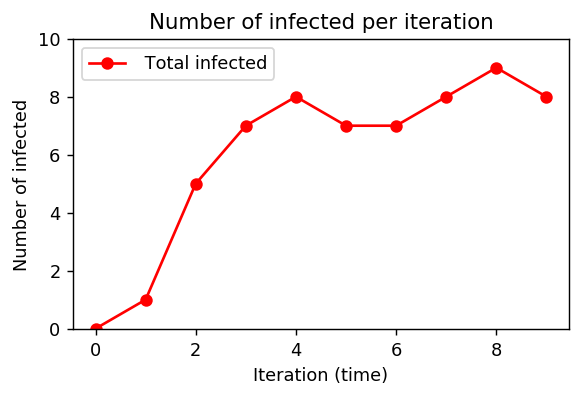

In [50]:
model = Model(num_of_agents=10, num_iterations=10, mode = 'homogeneous')
model.run()
model.graph_num_infected()

In [41]:
# model = Model(num_of_agents=100, num_iterations=10)
# model.run()
# model.graph_num_infected()

In [42]:
# model = Model(num_of_agents=1000, num_iterations=10)
# model.run()
# model.graph_num_infected()

In [43]:
# get_total = []
# #This runs the model 100 times, each model executing 10 steps.
# for j in range(100):
#     # Run the model
#     Model(num_of_agents=1000, num_iterations=10)
#     for i in range(10):
#         model.run()

#     # Store the results
#     for agent in model.agents:
#         get_total.append(model.get_num_infected())


In [44]:
# plt.rcParams["figure.figsize"] = (20,10)
# plt.rcParams.update({'font.size': 22})

# plt.hist(get_total, color='#0504aa', alpha=0.7, rwidth=0.85)

# plt.grid(axis='y', alpha=0.6)
# plt.xlabel('No. Infected')
# plt.ylabel('Frequency')
# plt.title('Distribution of Number of Infected over Time')